In [45]:
# https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline
import re
from gensim.models import word2vec
from bs4 import BeautifulSoup

//anaconda/lib/python2.7/site-packages/scikit_learn-0.18-py2.7-macosx-10.6-x86_64.egg/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('/Users/xingobar/Downloads/labeledTrainData.tsv',delimiter='\t',header=0,quoting=3)
test = pd.read_csv('/Users/xingobar/Downloads/testData.tsv',delimiter='\t',header=0,quoting=3)

In [14]:
###################
# remove stopword
##################
def review2word(review):
    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub('[^a-zA-Z]',' ',review_text)
    words = review_text.lower().split()
    stopword = set(stopwords.words('english'))
    cleared_word = [word for word in words if word not in stopword]
    return ' '.join(cleared_word)

In [21]:
ntrain = train.shape[0]
cleaned_review = []
for i in range(ntrain):
    if i % 2500 ==0:
        print('Proceed %d' %(i))
    cleaned_review.append(review2word(train['review'][i]))

Proceed 0
Proceed 2500
Proceed 5000
Proceed 7500
Proceed 10000
Proceed 12500
Proceed 15000
Proceed 17500
Proceed 20000
Proceed 22500


In [25]:
train['cleaned_review'] = cleaned_review
train.head()

,id,sentiment,review,cleaned_review
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",stuff going moment mj started listening music ...
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",classic war worlds timothy hines entertaining ...
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",film starts manager nicholas bell giving welco...
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",must assumed praised film greatest filmed oper...
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious explo...


In [28]:
vectorizer = CountVectorizer(analyzer='word',max_features=5000,stop_words=None,tokenizer=None)
bag_of_word = vectorizer.fit_transform(cleaned_review)
bag_of_word = bag_of_word.toarray()

In [33]:
unlabeld_train = pd.read_csv('/Users/xingobar/Downloads/unlabeledTrainData.tsv',delimiter='\t',header=0,quoting=3)

In [34]:
unlabeld_train.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [40]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',max_features=5000,stop_words=None,tokenizer=None)
tfidf = tfidf_vectorizer.fit_transform(cleaned_review)
tfidf = tfidf.toarray()
vocab = tfidf_vectorizer.get_feature_names()

In [42]:
print("Fitting tsne....")
tsne = TSNE(n_components=2,random_state=42)
tsne_word = tsne.fit_transform(tfidf[:2000,:])

Fitting tsne....


Plotting.....


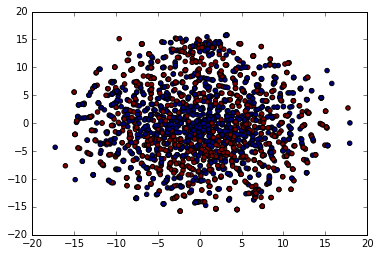

In [44]:
y_value = train['sentiment'].values
print('Plotting.....')
plt.figure()
plt.scatter(tsne_word[:,0],tsne_word[:,1],c=y_value[:2000])

In [47]:
dtrain = xgb.DMatrix(tfidf,label=y_value)
num_boost_rounds = 10
params = {
    'objective':'binary:logistic',
    'max_depth':10,
    'eval_matrix':'auc',
    'booster':'gbtree',
    'silent':1
}
print('Building the xgboost model....')
gbm = xgb.train(params,dtrain,num_boost_round=num_boost_rounds)

Building the xgboost model....


In [50]:
cleaned_test_review = []
for i in range(test.shape[0]):
    if i % 2500 ==0:
        print('Proceed %d ...'%(i))
    cleaned_test_review.append(review2word(test['review'][i]))


Proceed 0 ...
Proceed 2500 ...
Proceed 5000 ...
Proceed 7500 ...
Proceed 10000 ...
Proceed 12500 ...
Proceed 15000 ...
Proceed 17500 ...
Proceed 20000 ...
Proceed 22500 ...


In [55]:
test_feat = tfidf_vectorizer.transform(cleaned_test_review)
dtest = xgb.DMatrix(test_feat.toarray())
print('Predicting....')
y_pred = gbm.predict(dtest)
print('Creating submission...')
pd.DataFrame({'id':test['id'],'sentiment':y_pred}).to_csv('movie_sentiment_pred.csv',index=False,quoting=3)
print('Finished....')

Predicting....
Creating submission...
Finished....
